In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
train_data = pd.read_csv(
    "e-commerce-shoppers-behaviour-understanding/train_data_v2.csv"
)

In [52]:
cat_features = [col for col in train_data.columns if train_data[col].dtype == object]
print("Total categorical features:", len(cat_features))
num_features = [
    col for col in train_data.columns if train_data[col].dtype not in (object, bool)
]
print("Total numerical features:", len(num_features))

Total categorical features: 6
Total numerical features: 15


In [53]:
test_data = pd.read_csv("e-commerce-shoppers-behaviour-understanding/test_data_v2.csv")

In [54]:
feature = train_data.iloc[:, :-1]
label = train_data.iloc[:, -1]

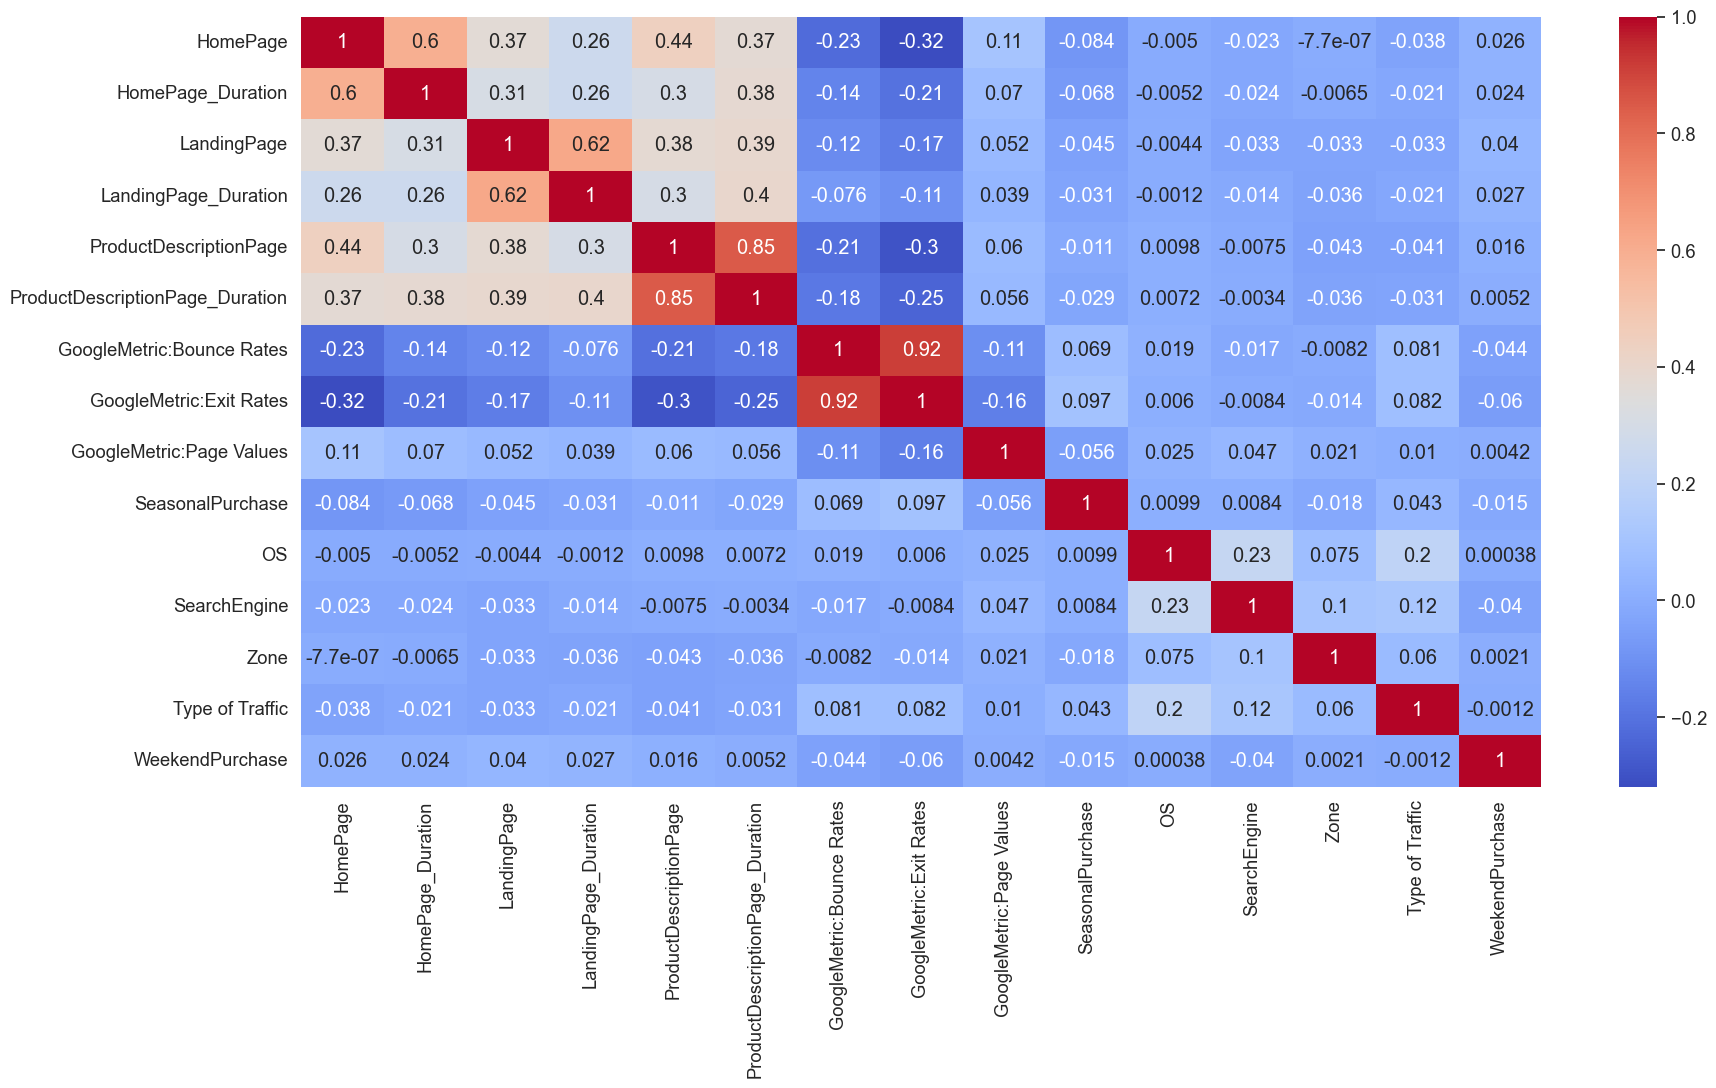

In [29]:
corr_mat = feature[num_features].corr()
sns.set(font_scale=1.2)
plt.figure(figsize=(20, 10))
sns.heatmap(corr_mat, cmap='coolwarm', annot=True)
plt.show()

In [55]:
num_features = [_ for _ in num_features if _ not in ('GoogleMetric:Exit Rates', 'ProductDesciptionPage', 'LandingPage')]
num_features

['HomePage',
 'HomePage_Duration',
 'LandingPage_Duration',
 'ProductDescriptionPage',
 'ProductDescriptionPage_Duration',
 'GoogleMetric:Bounce Rates',
 'GoogleMetric:Page Values',
 'SeasonalPurchase',
 'OS',
 'SearchEngine',
 'Zone',
 'Type of Traffic',
 'WeekendPurchase']

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [57]:
num_pipeline = Pipeline([("imputer", IterativeImputer()), ("scaler", StandardScaler())])

cat_pipeline = Pipeline(
    [
        ("encoder", OneHotEncoder()),
    ]
)

In [58]:
preprocessing_pipe = ColumnTransformer(
    [("num", num_pipeline, num_features), ("cat", cat_pipeline, cat_features)],
)

In [59]:
l_enc = LabelEncoder()
label = l_enc.fit_transform(label)

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(feature, label, test_size=0.2)

In [10]:
from sklearn.svm import SVC

In [11]:
clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        ("SVM", SVC()),
        #         ("SVM", SVC(C = 10, gamma = 0.01))
    ]
)

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
param_grid = {
    "SVM__kernel": ["linear", "poly", "rbf"],
    "SVM__C": [1, 10],
    "SVM__degree": [2, 3],
    "SVM__gamma": [0.01],
}

In [14]:
grid_clf = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=5,
    refit=True,
    n_jobs=2,
    return_train_score=True,
    verbose=2,
)

In [15]:
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HomePage',
                                                                          'HomePage_Duration',
                                                                          'LandingPage',
                                                                          'LandingPage_Duration',
                                                                          'ProductDescriptionPage',
                                                                          'ProductDescriptionPage_Duration',
                                                                          'GoogleMetric:Bounce '
                                                                          'Rates',
                                                                          'GoogleMetric:Exit '
                                                                          'Ra...
                                                                          'Traffic',
                                                                          'WeekendPurchase']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Month_SeasonalPurchase',
                                                                          'CustomerType',
                                                                          'Gender',
                                                                          'Cookies '
                                                                          'Setting',
                                                                          'Education',
                                                                          'Marital '
                                                                          'Status'])])),
                                       ('SVM', SVC())]),
             n_jobs=2,
             param_grid={'SVM__C': [1, 10], 'SVM__degree': [2, 3],
                         'SVM__gamma': [0.01],
                         'SVM__kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True, verbose=2)

In [16]:
grid_clf.best_params_

{'SVM__C': 10, 'SVM__degree': 2, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}

In [17]:
best_grid_clf = grid_clf.best_estimator_

best_grid_clf.fit(X_train, y_train)

best_grid_clf.score(X_val, y_val)

0.6635894651099647

In [18]:
y_hat_pred_val = best_grid_clf.predict(X_val)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_hat_pred_val))

              precision    recall  f1-score   support

       False       0.66      0.94      0.78      2274
        True       0.69      0.22      0.33      1409

    accuracy                           0.66      3683
   macro avg       0.67      0.58      0.55      3683
weighted avg       0.67      0.66      0.61      3683



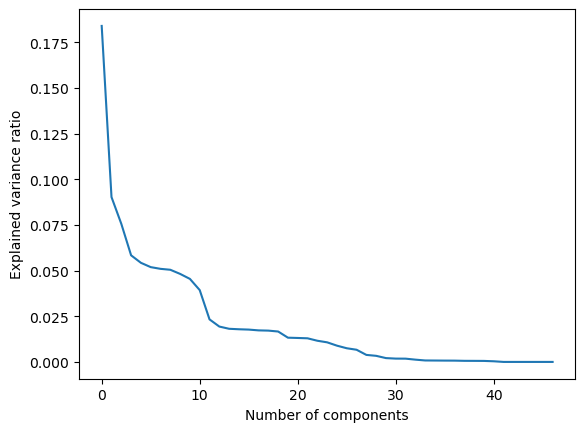

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

data = preprocessing_pipe.fit_transform(X_train)

# Fit PCA to the data
pca = PCA()
pca.fit(data)

# Plot the explained variance ratio
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.show()

In [13]:
# pca.explained_variance_ratio_[:23].sum()
# data.shape
for i in range(data.shape[1]):
    if round(pca.explained_variance_ratio_[:i].sum(), 2) >= 0.95:
        n_components = i
        break
n_components

23

In [20]:
clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        ("PCA", PCA(n_components=n_components)),
        ("SVM", SVC(C=10, degree=2, gamma=0.01, kernel="rbf")),
    ]
)

In [62]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Exit Rates',
                                                   'GoogleMetric:Page Values',
                                                   'SeasonalPurchase', 'OS',
                                                   'SearchEngine', 'Zone',
                                                   'Type of Traffic',
                                                   'WeekendPurchase']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Month_SeasonalPurchase',
                                                   'CustomerType', 'Gender',
                                                   'Cookies Setting',
                                                   'Education',
                                                   'Marital Status'])])),
                ('PCA', PCA(n_components=23)),
                ('SVM', SVC(C=10, degree=2, gamma=0.01))])

In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

       False       0.65      0.94      0.77      2282
        True       0.66      0.19      0.30      1401

    accuracy                           0.66      3683
   macro avg       0.66      0.57      0.54      3683
weighted avg       0.66      0.66      0.59      3683



In [21]:
param_grid = {
    "PCA__n_components": [23],
    "SVM__kernel": ["poly", "rbf"],
    "SVM__C": [1, 10],
    "SVM__degree": [2, 3],
    "SVM__gamma": [0.1, 0.01, 0.001],
}

In [22]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(
    clf,
    param_grid=param_grid,
    # cv=5,
    # refit=True,
    n_jobs=10,
    return_train_score=True,
    verbose=2,
)

In [23]:
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HomePage',
                                                                          'HomePage_Duration',
                                                                          'LandingPage',
                                                                          'LandingPage_Duration',
                                                                          'ProductDescriptionPage',
                                                                          'ProductDescriptionPage_Duration',
                                                                          'GoogleMetric:Bounce '
                                                                          'Rates',
                                                                          'GoogleMetric:Exit '
                                                                          'Rates',...
                                                                         ['Month_SeasonalPurchase',
                                                                          'CustomerType',
                                                                          'Gender',
                                                                          'Cookies '
                                                                          'Setting',
                                                                          'Education',
                                                                          'Marital '
                                                                          'Status'])])),
                                       ('PCA', PCA(n_components=23)),
                                       ('SVM',
                                        SVC(C=10, degree=2, gamma=0.01))]),
             n_jobs=10,
             param_grid={'PCA__n_components': [23], 'SVM__C': [1, 10],
                         'SVM__degree': [2, 3],
                         'SVM__gamma': [0.1, 0.01, 0.001],
                         'SVM__kernel': ['poly', 'rbf']},
             return_train_score=True, verbose=2)

In [24]:
grid_clf.best_params_

{'PCA__n_components': 23,
 'SVM__C': 10,
 'SVM__degree': 3,
 'SVM__gamma': 0.01,
 'SVM__kernel': 'rbf'}

In [25]:
grid_clf.best_estimator_.score(X_val, y_val)

0.6570730382840076

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        # ("PCA", PCA(n_components=n_components)),
        (
            "boost",
            AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.01
            ),
        ),
    ]
)

In [70]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Exit Rates',
                                                   'GoogleMetric:Page Values',
                                                   'SeasonalPurchase', 'OS',
                                                   'SearchEngine', 'Zone',
                                                   'Type of Traffic',
                                                   'WeekendPurchase']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Month_SeasonalPurchase',
                                                   'CustomerType', 'Gender',
                                                   'Cookies Setting',
                                                   'Education',
                                                   'Marital Status'])])),
                ('boost',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.01))])

In [71]:
clf.score(X_val, y_val)

0.671734998642411

In [65]:
from sklearn.model_selection import cross_validate

score = cross_validate(clf, X_train, y_train)
np.mean(score["test_score"])

0.6631060511400297

In [72]:
from sklearn.metrics import classification_report

print(classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

       False       0.67      0.91      0.77      2248
        True       0.68      0.30      0.42      1435

    accuracy                           0.67      3683
   macro avg       0.67      0.60      0.59      3683
weighted avg       0.67      0.67      0.63      3683



In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import NuSVC
# from sklearn.naive_bayes import BernoulliNB

# param_grid = {
#     "boost__n_estimators": [150, 200, 250],
#     "boost__learning_rate": [0.01, 0.02, 0.1],
#     "boost__base_estimator": [
#         DecisionTreeClassifier(max_depth=3),
#     ],
#     "boost__algorithm": ["SAMME", "SAMME.R"],
# }

param_grid = {
    "boost__n_estimators": [200],
    "boost__learning_rate": [0.035, 0.04, 0.045],
    "boost__base_estimator": [
        DecisionTreeClassifier(max_depth=3),
    ],
    "boost__algorithm": ["SAMME"],
}

In [37]:
clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        # ("PCA", PCA(n_components=n_components)),
        (
            "boost",
            AdaBoostClassifier(),
        ),
    ]
)

In [38]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(
    clf,
    param_grid=param_grid,
    # cv=5,
    # refit=True,
    n_jobs=10,
    return_train_score=True,
    verbose=2,
)

In [39]:
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HomePage',
                                                                          'HomePage_Duration',
                                                                          'LandingPage',
                                                                          'LandingPage_Duration',
                                                                          'ProductDescriptionPage',
                                                                          'ProductDescriptionPage_Duration',
                                                                          'GoogleMetric:Bounce '
                                                                          'Rates',
                                                                          'GoogleMetric:Exit '
                                                                          'Rates',...
                                                                         ['Month_SeasonalPurchase',
                                                                          'CustomerType',
                                                                          'Gender',
                                                                          'Cookies '
                                                                          'Setting',
                                                                          'Education',
                                                                          'Marital '
                                                                          'Status'])])),
                                       ('boost', AdaBoostClassifier())]),
             n_jobs=10,
             param_grid={'boost__algorithm': ['SAMME'],
                         'boost__base_estimator': [DecisionTreeClassifier(max_depth=3)],
                         'boost__learning_rate': [0.035, 0.04, 0.045],
                         'boost__n_estimators': [200]},
             return_train_score=True, verbose=2)

In [40]:
grid_clf.best_params_

{'boost__algorithm': 'SAMME',
 'boost__base_estimator': DecisionTreeClassifier(max_depth=3),
 'boost__learning_rate': 0.04,
 'boost__n_estimators': 200}

In [41]:
grid_clf.best_estimator_.score(X_val, y_val)

0.6652185718164539

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

cv = StratifiedShuffleSplit(n_splits=10)

scores = cross_validate(grid_clf.best_estimator_, X_train, y_train, cv=cv)
print(np.mean(scores["test_score"]))

0.6655203619909503


In [50]:
clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        # ("PCA", PCA(n_components=n_components)),
        (
            "boost",
            AdaBoostClassifier(
                learning_rate=0.04,
                n_estimators=200,
                algorithm="SAMME",
                base_estimator=DecisionTreeClassifier(max_depth=3),
            ),
        ),
    ]
)

In [51]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Exit Rates',
                                                   'GoogleMetric:Page Values',
                                                   '...S',
                                                   'SearchEngine', 'Zone',
                                                   'Type of Traffic',
                                                   'WeekendPurchase']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Month_SeasonalPurchase',
                                                   'CustomerType', 'Gender',
                                                   'Cookies Setting',
                                                   'Education',
                                                   'Marital Status'])])),
                ('boost',
                 AdaBoostClassifier(algorithm='SAMME',
                                    base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.01, n_estimators=200))])

In [52]:
clf.score(X_val, y_val)

0.6652185718164539

In [53]:
scores = cross_validate(clf, X_train, y_train, cv=cv)
print(np.mean(scores["test_score"]))

0.6667873303167422


In [10]:
from sklearn.ensemble import GradientBoostingClassifier

In [11]:
clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        ("boost", GradientBoostingClassifier()),
    ]
)

In [12]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Exit Rates',
                                                   'GoogleMetric:Page Values',
                                                   'SeasonalPurchase', 'OS',
                                                   'SearchEngine', 'Zone',
                                                   'Type of Traffic',
                                                   'WeekendPurchase']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Month_SeasonalPurchase',
                                                   'CustomerType', 'Gender',
                                                   'Cookies Setting',
                                                   'Education',
                                                   'Marital Status'])])),
                ('boost', GradientBoostingClassifier())])

In [14]:
clf.score(X_val, y_val)

0.6638609828943796

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)
scores = cross_validate(clf, X_train, y_train, cv=cv)
print(np.mean(scores["test_score"]))

0.6656046343229544


In [48]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "boost__loss": ["log_loss", "exponential"],
    "boost__criterion": ["friedman_mse", "squared_error"],
    "boost__learning_rate": [0.015, 0.02, 0.025],
    "boost__n_estimators": [100, 150, 200],
    "boost__max_depth": [2, 3, 4],
    "boost__max_features": [None, "sqrt", "log2"],
    "boost__min_samples_split": [2, 4, 8],
    "boost__min_samples_leaf": [1, 2, 4],
    "boost__warm_start": [True],
    "boost__n_iter_no_change": [5],
    "boost__tol": [1e-4],
}

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)

rnd_clf = RandomizedSearchCV(
    clf,
    param_distributions=param_distributions,
    n_iter=100,
    cv=cv,
    # refit=True,
    n_jobs=10,
    return_train_score=True,
    verbose=2,
)

In [51]:
rnd_clf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.25,
            train_size=None),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['HomePage',
                                                                                'HomePage_Duration',
                                                                                'LandingPage',
                                                                                'LandingPage_Duration',
                                                                                'ProductDescriptionPa...
                                        'boost__learning_rate': [0.015, 0.02,
                                                                 0.025],
                                        'boost__loss': ['log_loss',
                                                        'exponential'],
                                        'boost__max_depth': [2, 3, 4],
                                        'boost__max_features': [None, 'auto',
                                                                'sqrt',
                                                                'log2'],
                                        'boost__min_samples_leaf': [1, 2, 4],
                                        'boost__min_samples_split': [2, 4, 8],
                                        'boost__n_estimators': [100, 150, 200],
                                        'boost__n_iter_no_change': [5],
                                        'boost__tol': [0.0001],
                                        'boost__warm_start': [True]},
                   return_train_score=True, verbose=2)

In [52]:
rnd_clf.best_params_

{'boost__warm_start': True,
 'boost__tol': 0.0001,
 'boost__n_iter_no_change': 5,
 'boost__n_estimators': 200,
 'boost__min_samples_split': 4,
 'boost__min_samples_leaf': 1,
 'boost__max_features': None,
 'boost__max_depth': 3,
 'boost__loss': 'log_loss',
 'boost__learning_rate': 0.015,
 'boost__criterion': 'friedman_mse'}

In [53]:
rnd_clf.best_estimator_.score(X_val, y_val)

0.6652185718164539

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)
scores = cross_validate(rnd_clf.best_estimator_, X_train, y_train, cv=cv)
print(np.mean(scores["test_score"]))

0.6681028240405503


In [62]:
from sklearn.ensemble import AdaBoostClassifier

clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        # ("PCA", PCA(n_components=n_components)),
        (
            "boost",
            AdaBoostClassifier(),
        ),
    ]
)

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    "boost__n_estimators": [150, 200, 250],
    "boost__learning_rate": [0.04, 0.045, 0.05],
    "boost__base_estimator": [
        RandomForestClassifier(n_estimators=5, max_depth=2),
        # RandomForestClassifier(n_estimators=3, max_depth=3),
        DecisionTreeClassifier(max_depth=3),
    ],
    "boost__algorithm": ["SAMME"],
}

In [110]:
grid_clf = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=5,
    # refit=True,
    n_jobs=10,
    return_train_score=True,
    verbose=2,
)

In [111]:
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HomePage',
                                                                          'HomePage_Duration',
                                                                          'LandingPage',
                                                                          'LandingPage_Duration',
                                                                          'ProductDescriptionPage',
                                                                          'ProductDescriptionPage_Duration',
                                                                          'GoogleMetric:Bounce '
                                                                          'Rates',
                                                                          'GoogleMetric:Exit '
                                                                          'Ra...
                                                                          'Setting',
                                                                          'Education',
                                                                          'Marital '
                                                                          'Status'])])),
                                       ('boost', AdaBoostClassifier())]),
             n_jobs=10,
             param_grid={'boost__algorithm': ['SAMME'],
                         'boost__base_estimator': [RandomForestClassifier(max_depth=2,
                                                                          n_estimators=5),
                                                   DecisionTreeClassifier(max_depth=3)],
                         'boost__learning_rate': [0.04, 0.045, 0.05],
                         'boost__n_estimators': [150, 200, 250]},
             return_train_score=True, verbose=2)

In [112]:
grid_clf.best_params_

{'boost__algorithm': 'SAMME',
 'boost__base_estimator': DecisionTreeClassifier(max_depth=3),
 'boost__learning_rate': 0.045,
 'boost__n_estimators': 250}

In [113]:
grid_clf.score(X_val, y_val)

0.6660331251696986

In [114]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)
scores = cross_validate(grid_clf.best_estimator_, X_train, y_train, cv=cv)
print(np.mean(scores["test_score"]))

0.6673787110789283


In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        # ("PCA", PCA(n_components=n_components)),
        (
            "nn",
            MLPClassifier(
                hidden_layer_sizes=(300, 300),
                learning_rate="adaptive",
                solver="lbfgs",
                max_iter=300,
            ),
        ),
    ]
)

In [31]:
clf.fit(X_train, y_train)

C:\Users\sayan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Exit Rates',
                                                   'GoogleMetric:Page Values',
                                                   'SeasonalPurchase', 'OS',
                                                   'SearchEngine', 'Zone',
                                                   'Type of Traffic',
                                                   'WeekendPurchase']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Month_SeasonalPurchase',
                                                   'CustomerType', 'Gender',
                                                   'Cookies Setting',
                                                   'Education',
                                                   'Marital Status'])])),
                ('nn',
                 MLPClassifier(hidden_layer_sizes=(300, 300),
                               learning_rate='adaptive', max_iter=300,
                               solver='lbfgs'))])

In [32]:
clf.score(X_val, y_val)

0.4732554982351344

In [18]:
pd.DataFrame(y_train).value_counts()

Made_Purchase
False            6779
True             4269
dtype: int64

In [11]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# class SmoteTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, **smote_kwargs):
#         self.smote_kwargs = smote_kwargs
#         self.smote = SMOTE(**smote_kwargs)

#     def fit(self, X, y):
#         self.X_ = X
#         self.y_ = y
#         return self

#     def transform(self, X, y=None):
#         X_resampled, y_resampled = self.smote.fit_resample(self.X_, self.y_)
#         return X_resampled, y_resampled

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# clf = ImbPipeline(
#     [
#         ("preprocess", preprocessing_pipe),
#         ("smote", SmoteTransformer()),
#         ("boost", AdaBoostClassifier()),
#     ]
# )

estimators = [
    ("rf", RandomForestClassifier(n_estimators=500, max_features="log2")),
    # ("boost", AdaBoostClassifier(n_estimators=25, learning_rate=0.75)),
    (
        "logit",
        LogisticRegression(
            solver="saga", C=0.1, penalty="l2", multi_class="multinomial", max_iter=2000
        ),
    ),
    ("nb", BernoulliNB()),
    # ("dt", DecisionTreeClassifier(max_depth = 2)),
    (
        "svc",
        SVC(C=0.1, degree=2, gamma="auto", kernel="poly"),
    ),
    # ("mlp", MLPClassifier(max_iter=1000)),
    ("n_centroid", NearestCentroid()),
]

clf = ImbPipeline(
    [
        ("preprocess", preprocessing_pipe),
        # SMOTE(n_jobs=-1, random_state=42),
        (
            "sc",
            StackingClassifier(
                estimators=estimators,
                final_estimator=AdaBoostClassifier(n_estimators=25, learning_rate=0.75),
            ),
        ),
    ]
)

clf.fit(X_train, y_train)
# X_train.shape

In [ ]:
clf.score(X_val, y_val)

In [110]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek


In [112]:
smote_to = SMOTETomek(n_jobs=-1)
X_train_pre = preprocessing_pipe.fit_transform(X_train)
X_train_comb, y_train_comb = smote_to.fit_resample(X_train_pre, y_train)

C:\Users\sayan\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [113]:
estimators = [
    ("rf", RandomForestClassifier(n_estimators=500, max_features="log2", random_state=42)),
    (
        "gb",
        GradientBoostingClassifier(
            warm_start=True,
            tol=0.0001,
            n_iter_no_change=5,
            n_estimators=200,
            min_samples_split=4,
            min_samples_leaf=1,
            max_features=None,
            max_depth=3,
            loss="log_loss",
            learning_rate=0.015,
            criterion="friedman_mse",
        ),
    ),
    (
        "logit",
        LogisticRegression(
            solver="saga", C=0.1, penalty="l2", multi_class="multinomial", max_iter=2000
        ),
    ),
    # (
    #     "svc",
    #     SVC(C=10, degree=2, gamma=0.01, kernel="rbf", probability=True),
    # ),
    ("nb", BernoulliNB()),
    ("nc", NearestCentroid())
]

In [114]:
clf = Pipeline(
    [
        # ("preprocessing", preprocessing_pipe),
        (
            "stacking",
            StackingClassifier(
                estimators=estimators,
                final_estimator=AdaBoostClassifier(
                    estimator=DecisionTreeClassifier(max_depth=2),
                    learning_rate=0.05,
                ),
                passthrough=True,
                stack_method="auto",
                cv=StratifiedKFold(n_splits=5, shuffle=True),
                n_jobs=-1,
            ),
        ),
    ]
)

In [115]:
clf.fit(X_train_comb, y_train_comb)

Pipeline(steps=[('stacking',
                 StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x1D727BD5240, shuffle=True),
                                    estimators=[('rf',
                                                 RandomForestClassifier(max_features='log2',
                                                                        n_estimators=500,
                                                                        random_state=42)),
                                                ('gb',
                                                 GradientBoostingClassifier(learning_rate=0.015,
                                                                            min_samples_split=4,
                                                                            n_estimators=200,
                                                                            n_iter_no_change=5,
                                                                            warm_start=True)),
                                                ('logit',
                                                 LogisticRegression(C=0.1,
                                                                    max_iter=2000,
                                                                    multi_class='multinomial',
                                                                    solver='saga')),
                                                ('nb', BernoulliNB()),
                                                ('nc', NearestCentroid())],
                                    final_estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                                                       learning_rate=0.05),
                                    n_jobs=-1, passthrough=True))])

In [116]:
X_val_pre = preprocessing_pipe.fit_transform(X_val)

In [117]:
clf.score(X_val_pre, y_val) # using SMOTE

0.38717339667458434

In [118]:
print(classification_report(y_val, clf.predict(X_val_pre)))

              precision    recall  f1-score   support

           0       0.38      0.00      0.00      1804
           1       0.39      1.00      0.56      1143

    accuracy                           0.39      2947
   macro avg       0.38      0.50      0.28      2947
weighted avg       0.38      0.39      0.22      2947



In [25]:
clf.score(X_val, y_val) # including all classifiers

0.7790973871733967

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1788
           1       0.78      0.62      0.69      1159

    accuracy                           0.78      2947
   macro avg       0.78      0.75      0.76      2947
weighted avg       0.78      0.78      0.77      2947



In [18]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

f1 = make_scorer(f1_score, greater_is_better=True)

In [ ]:
param_grid = {
    "stacking__nb__alpha": [0.1],# 0.5, 1.0, 2.0],
    "stacking__nb__binarize": [0.0, 0.1, 0.5, 1.0],
    "stacking__nb__fit_prior": [True, False],
    "stacking__nb__class_prior": [(0.38, 0.62)],
}

In [ ]:
grid_clf = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=f1,
    verbose=3,
)

In [28]:
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HomePage',
                                                                          'HomePage_Duration',
                                                                          'LandingPage',
                                                                          'LandingPage_Duration',
                                                                          'ProductDescriptionPage',
                                                                          'ProductDescriptionPage_Duration',
                                                                          'GoogleMetric:Bounce '
                                                                          'Rates',
                                                                          'GoogleMetric:Exit '
                                                                          'Ra...
                                                                        BernoulliNB())],
                                                           final_estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                                                                                              learning_rate=0.01),
                                                           n_jobs=-1,
                                                           passthrough=True,
                                                           stack_method='predict_proba'))]),
             n_jobs=-1,
             param_grid={'stacking__nb__alpha': [0.1],
                         'stacking__nb__binarize': [0.0, 0.1, 0.5, 1.0],
                         'stacking__nb__fit_prior': [True, False]},
             scoring=make_scorer(f1_score), verbose=3)

In [29]:
grid_clf.best_model_.score(X_val, y_val)

AttributeError: 'GridSearchCV' object has no attribute 'best_model_'

In [18]:
X_train_pre = preprocessing_pipe.fit_transform(X_train)

In [27]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, learning_curve

In [32]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train)
display = LearningCurveDisplay(
    train_sizes=train_sizes,
    train_scores=train_scores,
    test_scores=test_scores,
    score_name="f1",
)

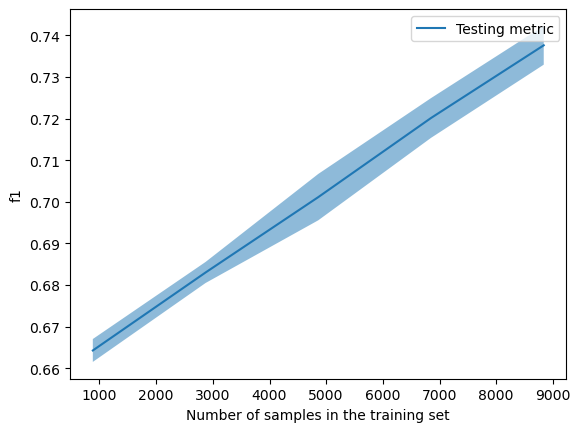

In [33]:
display.plot()

In [113]:
y_hat_val_pred = clf.predict(X_val)

In [106]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

In [107]:
fpr, tpr, thresholds = roc_curve(y_val, y_hat_val_pred)
roc_auc = auc(fpr, tpr)

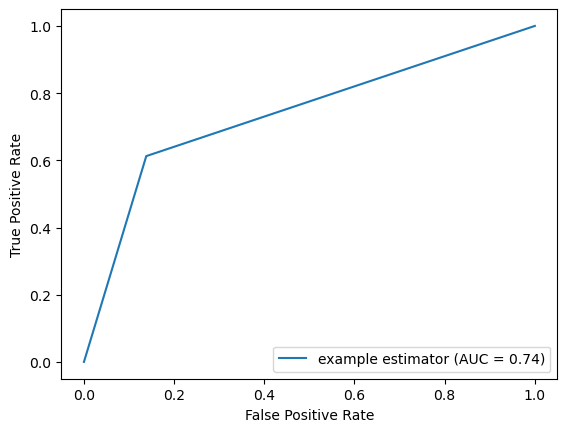

In [109]:
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="example estimator"
)
display.plot()

In [115]:
from sklearn.metrics import classification_report

scores = classification_report(y_val, y_hat_val_pred)
print(scores)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2279
           1       0.73      0.61      0.67      1404

    accuracy                           0.77      3683
   macro avg       0.76      0.74      0.74      3683
weighted avg       0.76      0.77      0.76      3683



In [118]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([6786, 4262], dtype=int64))

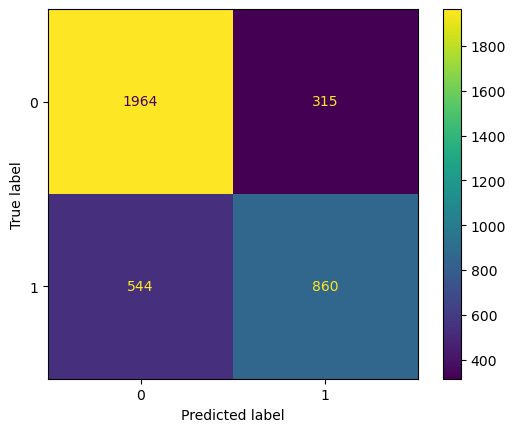

In [112]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_val, clf.predict(X_val))

In [46]:
clf.score(X_val, y_val)

0.7664947054032039

In [78]:
from sklearn.model_selection import StratifiedKFold, cross_validate

In [80]:
cv = StratifiedKFold(n_splits=10)
scores = cross_validate(
    clf,
    X_train,
    y_train,
    cv=cv,
    verbose=3,
    return_train_score=True,
    n_jobs=-1,
    scoring="f1",
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  5.9min remaining: 13.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  6.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.3min finished


In [83]:
np.mean(scores["train_score"])

0.21441288228676836

In [65]:
clf.score(
    X_val, y_val
)  # with rand forest & logit + final estimator --> passthrough=True & stack_method="predict_proba" SCORE = 0.76405104534347

0.7616073852837361

In [36]:
clf.score(
    X_val, y_val
)  # with rand forest & logit + final estimator --> passthrough=True & stack_method="predict_proba" SCORE = 0.7591637252240022

0.7591637252240022

In [77]:
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

estimators = [
    (
        "rf",
        RandomForestClassifier(
            n_estimators=500,
        ),
    ),
    (
        "logit",
        LogisticRegression(
            # solver="saga", C=0.5, penalty="l2", multi_class="multinomial", max_iter=1500
        ),
    ),
    ("dt", DecisionTreeClassifier(max_depth=2)),
    # (
    #     "svc",
    #     SVC(C=0.1, degree=2, gamma="auto", kernel="poly"),
    # ),
    # ("mlp", MLPClassifier(max_iter=1000)),
]


clf1 = StackingClassifier(
    estimators=estimators,
    final_estimator=AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=2),
        learning_rate=0.01,
    ),
    passthrough=True,
    stack_method="predict_proba",
    n_jobs=-1,
)
clf2 = StackingClassifier(
    estimators=estimators,
    final_estimator=AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=2),
        learning_rate=0.01,
    ),
    passthrough=True,
    stack_method="predict_proba",
    n_jobs=-1,
)
clf3 = StackingClassifier(
    estimators=estimators,
    final_estimator=AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=2),
        learning_rate=0.01,
    ),
    passthrough=True,
    stack_method="predict_proba",
    n_jobs=-1,
)

estimators_2 = [("clf1", clf1), ("clf2", clf2), ("clf3", clf3)]

In [11]:
# Hyperparameters clf
param_grid = {
    "stacking__rf__n_estimators": [450, 500, 550],
    "stacking__rf__max_features": ["sqrt", "log2", None],
    "stacking__logit__C": [0.5],
    "stacking__logit__solver": ["saga"],
    "stacking__logit__penalty": ["l2"],
    "stacking__logit__multi_class": ["multinomial"],
    "stacking__logit__max_iter": [1450, 1500, 1550],
    "stacking__final_estimator__n_estimators": [25, 50, 75],
    "stacking__final_estimator__learning_rate": [0.25, 0.5, 0.75],
}

In [78]:
# from sklearn.neural_network import BernoulliRBM

# clf = Pipeline(
#     [
#         ("preprocessing", preprocessing_pipe),
#         # ("b_rbm", BernoulliRBM(learning_rate=0.001)),
#         (
#             "stacking",
#             StackingClassifier(
#                 estimators=estimators,
#                 # final_estimator=LogisticRegression(
#                 #     solver="saga", C=10, penalty="l1", multi_class="multinomial"
#                 # ),
#                 final_estimator=AdaBoostClassifier(),
#                 # final_estimator=MLPClassifier(max_iter=500)
#             ),
#         ),
#     ]
# )


clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        # ("b_rbm", BernoulliRBM(learning_rate=0.001)),
        (
            "stacking",
            StackingClassifier(
                estimators=estimators,
                # final_estimator=LogisticRegression(
                #     solver="saga", C=10, penalty="l1", multi_class="multinomial"
                # ),
                final_estimator=AdaBoostClassifier(
                    base_estimator=DecisionTreeClassifier(max_depth=2),
                    learning_rate=0.01,
                ),
                passthrough=True,
                stack_method="predict_proba",
                n_jobs=-1,
            ),
        ),
    ]
)

In [79]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Exit Rates',
                                                   'GoogleMetric:Page Values',
                                                   '...
                                                   'Marital Status'])])),
                ('stacking',
                 StackingClassifier(estimators=[('rf',
                                                 RandomForestClassifier(n_estimators=500)),
                                                ('logit', LogisticRegression()),
                                                ('dt',
                                                 DecisionTreeClassifier(max_depth=2))],
                                    final_estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                                                       learning_rate=0.01),
                                    n_jobs=-1, passthrough=True,
                                    stack_method='predict_proba'))])

In [80]:
clf.score(X_val, y_val)

0.748303013847407

In [13]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

f1 = make_scorer(f1_score, greater_is_better=True)

rnd_clf = GridSearchCV(
    clf,
    param_grid=param_grid,
    # param_distributions=param_grid,
    # n_iter=100,
    cv=5,
    n_jobs=-1,
    scoring=f1,
    verbose=2,
    # random_state=42
)

In [14]:
rnd_clf.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['HomePage',
                                                                          'HomePage_Duration',
                                                                          'LandingPage',
                                                                          'LandingPage_Duration',
                                                                          'ProductDescriptionPage',
                                                                          'ProductDescriptionPage_Duration',
                                                                          'GoogleMetric:Bounce '
                                                                          'Rates',
                                                                          'GoogleMetric:Exit '
                                                                          'Ra...
                         'stacking__final_estimator__n_estimators': [25, 50,
                                                                     75],
                         'stacking__logit__C': [0.5],
                         'stacking__logit__max_iter': [1450, 1500, 1550],
                         'stacking__logit__multi_class': ['multinomial'],
                         'stacking__logit__penalty': ['l2'],
                         'stacking__logit__solver': ['saga'],
                         'stacking__rf__max_features': ['sqrt', 'log2', None],
                         'stacking__rf__n_estimators': [450, 500, 550]},
             scoring=make_scorer(f1_score), verbose=2)

In [15]:
# clf.score(X_train, y_train)
rnd_clf.best_params_

{'stacking__final_estimator__learning_rate': 0.75,
 'stacking__final_estimator__n_estimators': 25,
 'stacking__logit__C': 0.5,
 'stacking__logit__max_iter': 1550,
 'stacking__logit__multi_class': 'multinomial',
 'stacking__logit__penalty': 'l2',
 'stacking__logit__solver': 'saga',
 'stacking__rf__max_features': 'log2',
 'stacking__rf__n_estimators': 500}

In [16]:
rnd_clf.best_estimator_.score(X_val, y_val)

0.743958729296769

In [ ]:
"""
{'stacking__rf__n_estimators': 500,
 'stacking__rf__max_features': 'log2',
 'stacking__logit__solver': 'saga',
 'stacking__logit__penalty': 'l2',
 'stacking__logit__multi_class': 'multinomial',
 'stacking__logit__max_iter': 2000,
 'stacking__logit__C': 0.1,
 'stacking__final_estimator__n_estimators': 50,
 'stacking__final_estimator__learning_rate': 0.5}
 """

In [23]:
rnd_clf.best_estimator_.score(X_val, y_val)  # nested stacking

0.7561770295954385

In [37]:
clf.score(X_val, y_val)

0.7521042628292153

In [40]:
# from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25)
# scores = cross_validate(clf, X_train, y_train, cv=cv)

In [41]:
# np.mean(scores["test_score"])

0.6673425054308472

In [115]:
from sklearn.metrics import classification_report

print(classification_report(clf.predict(X_val), y_val))  # LOGIT

              precision    recall  f1-score   support

       False       0.92      0.71      0.80      2913
        True       0.42      0.77      0.54       770

    accuracy                           0.73      3683
   macro avg       0.67      0.74      0.67      3683
weighted avg       0.82      0.73      0.75      3683



In [17]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(clf.predict(X_val), y_val))  # Voting

              precision    recall  f1-score   support

       False       0.94      0.66      0.78      3234
        True       0.22      0.67      0.33       449

    accuracy                           0.67      3683
   macro avg       0.58      0.67      0.55      3683
weighted avg       0.85      0.67      0.72      3683



In [121]:
from sklearn.metrics import classification_report

print(classification_report(clf.predict(X_val), y_val))  # ADA BOOST

              precision    recall  f1-score   support

       False       0.83      0.76      0.79      2493
        True       0.57      0.69      0.63      1190

    accuracy                           0.73      3683
   macro avg       0.70      0.72      0.71      3683
weighted avg       0.75      0.73      0.74      3683



In [139]:
# from sklearn.metrics import classification_report

# print(classification_report(clf.predict(X_val), y_val))  # ADA BOOST (DT max_depth = 2)

In [138]:
from sklearn.metrics import classification_report

print(classification_report(clf.predict(X_val), y_val))  # SVC C=0.1

              precision    recall  f1-score   support

       False       0.84      0.76      0.80      2512
        True       0.57      0.69      0.63      1171

    accuracy                           0.74      3683
   macro avg       0.71      0.73      0.71      3683
weighted avg       0.76      0.74      0.74      3683



In [146]:
from sklearn.metrics import classification_report

print(classification_report(clf.predict(X_val), y_val))  # SVC C=0.1, random_forest=45

              precision    recall  f1-score   support

       False       0.87      0.75      0.80      2675
        True       0.51      0.70      0.59      1008

    accuracy                           0.73      3683
   macro avg       0.69      0.72      0.70      3683
weighted avg       0.77      0.73      0.74      3683



In [ ]:
from sklearn.metrics import classification_report  # n_est = 55

print(classification_report(clf.predict(X_val), y_val))  # 3 logit C=0.5 poly

              precision    recall  f1-score   support

       False       0.87      0.76      0.81      2637
        True       0.54      0.72      0.61      1046

    accuracy                           0.75      3683
   macro avg       0.70      0.74      0.71      3683
weighted avg       0.78      0.75      0.75      3683



In [440]:
from sklearn.metrics import classification_report

print(
    classification_report(clf.predict(X_val), y_val)
)  # l1 rbf n_est=500 logit__C=0.5 SVC__C=0.1 SVM__degree=2 SVM__gamma="auto"

              precision    recall  f1-score   support

       False       0.85      0.77      0.81      2552
        True       0.57      0.70      0.63      1131

    accuracy                           0.75      3683
   macro avg       0.71      0.74      0.72      3683
weighted avg       0.77      0.75      0.75      3683



In [432]:
from sklearn.metrics import classification_report

print(
    classification_report(clf.predict(X_val), y_val)
)  # l1 poly n_est=500 logit__C=0.5 SVC__C=0.1 SVM__degree=2 SVM__gamma="auto"

              precision    recall  f1-score   support

       False       0.88      0.76      0.82      2656
        True       0.54      0.74      0.63      1027

    accuracy                           0.75      3683
   macro avg       0.71      0.75      0.72      3683
weighted avg       0.79      0.75      0.76      3683



In [11]:
from xgboost import XGBClassifier

from sklearn.ense

clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        ("XGB", XGBClassifier())
    ]
)

In [12]:
clf.fit(X_train, y_train)

C:\Users\sayan\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:10:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Exit Rates',
                                                   'GoogleMetric:Page Values',
                                                   '...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [14]:
clf.score(X_val, y_val)

0.5965245723594895

In [39]:
from sklearn.metrics import classification_report

print(classification_report(clf.predict(X_val), y_val))  # Extreme stacking

              precision    recall  f1-score   support

       False       0.85      0.77      0.81      2476
        True       0.60      0.71      0.65      1207

    accuracy                           0.75      3683
   macro avg       0.72      0.74      0.73      3683
weighted avg       0.77      0.75      0.76      3683



In [111]:
from sklearn.ensemble import VotingClassifier

In [165]:
estimators = [
    # ("rf", RandomForestClassifier(n_estimators=500, max_features="log2", random_state=42)),
    (
        "gb",
        GradientBoostingClassifier(
            warm_start=True,
            tol=0.0001,
            n_iter_no_change=5,
            n_estimators=200,
            min_samples_split=4,
            min_samples_leaf=1,
            max_features=None,
            max_depth=3,
            loss="log_loss",
            learning_rate=0.015,
            criterion="friedman_mse",
        ),
    ),
    (
        "logit",
        LogisticRegression(
            solver="saga", C=0.1, penalty="l2", multi_class="multinomial", max_iter=2000
        ),
    ),
    (
        "svc",
        SVC(C=10, degree=2, gamma=0.01, kernel="rbf", probability=True),
    ),
    ("nb", BernoulliNB()),
    ("boost", AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=2),
        learning_rate=0.01,
    )),
    # ("nc", NearestCentroid())
]

In [167]:
clf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        (
            "voting",
            VotingClassifier(
                estimators=estimators,
                voting='soft',
                flatten_transform=True,
                n_jobs=-1,
            ),
        ),
    ]
)

In [168]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Page Values',
                                                   'SeasonalPurchase', 'OS',
                                                   'SearchEng...
                                                                          min_samples_split=4,
                                                                          n_estimators=200,
                                                                          n_iter_no_change=5,
                                                                          warm_start=True)),
                                              ('logit',
                                               LogisticRegression(C=0.1,
                                                                  max_iter=2000,
                                                                  multi_class='multinomial',
                                                                  solver='saga')),
                                              ('svc',
                                               SVC(C=10, degree=2, gamma=0.01,
                                                   probability=True)),
                                              ('nb', BernoulliNB()),
                                              ('boost',
                                               AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                                                  learning_rate=0.01))],
                                  n_jobs=-1, voting='soft'))])

In [169]:
clf.score(X_val, y_val)

0.6687483030138474

In [123]:
clf_gb = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        (
        "gb",
        GradientBoostingClassifier(
            warm_start=True,
            tol=0.0001,
            n_iter_no_change=5,
            n_estimators=200,
            min_samples_split=4,
            min_samples_leaf=1,
            max_features=None,
            max_depth=3,
            loss="log_loss",
            learning_rate=0.015,
            criterion="friedman_mse",
         ),
        )
    ]
)

In [124]:
clf_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Page Values',
                                                   'SeasonalPurchase', 'OS',
                                                   'SearchEngine', 'Zone',
                                                   'Type of Traffic',
                                                   'WeekendPurchase']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Month_SeasonalPurchase',
                                                   'CustomerType', 'Gender',
                                                   'Cookies Setting',
                                                   'Education',
                                                   'Marital Status'])])),
                ('gb',
                 GradientBoostingClassifier(learning_rate=0.015,
                                            min_samples_split=4,
                                            n_estimators=200,
                                            n_iter_no_change=5,
                                            warm_start=True))])

In [126]:
clf_gb.score(X_val, y_val)

0.6657616073852838

In [127]:
from sklearn.metrics import classification_report

print(classification_report(y_val, clf_gb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.66      0.93      0.77      2261
           1       0.68      0.25      0.37      1422

    accuracy                           0.67      3683
   macro avg       0.67      0.59      0.57      3683
weighted avg       0.67      0.67      0.62      3683



In [130]:
clf_rf = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        (
            "random_forest", RandomForestClassifier(n_estimators=500, max_features="log2", random_state=42),
        )
    ]
)

In [131]:
clf_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Page Values',
                                                   'SeasonalPurchase', 'OS',
                                                   'SearchEngine', 'Zone',
                                                   'Type of Traffic',
                                                   'WeekendPurchase']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Month_SeasonalPurchase',
                                                   'CustomerType', 'Gender',
                                                   'Cookies Setting',
                                                   'Education',
                                                   'Marital Status'])])),
                ('random_forest',
                 RandomForestClassifier(max_features='log2', n_estimators=500,
                                        random_state=42))])

In [132]:
clf.score(X_val, y_val)

0.6581591094216671

In [134]:
from sklearn.metrics import classification_report

print(classification_report(y_val, clf_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.60      0.70      0.65      2261
           1       0.34      0.24      0.29      1422

    accuracy                           0.53      3683
   macro avg       0.47      0.47      0.47      3683
weighted avg       0.50      0.53      0.51      3683



In [171]:
clf_logit = Pipeline(
    [
        ("preprocessing", preprocessing_pipe),
        (
        "logit",
        LogisticRegression(
            solver="saga", C=0.1, penalty="l2", multi_class="multinomial", max_iter=2000
         )
        )
    ]
)

In [172]:
clf_logit.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['HomePage',
                                                   'HomePage_Duration',
                                                   'LandingPage_Duration',
                                                   'ProductDescriptionPage',
                                                   'ProductDescriptionPage_Duration',
                                                   'GoogleMetric:Bounce Rates',
                                                   'GoogleMetric:Page Values',
                                                   'SeasonalPurchase', 'OS',
                                                   'SearchEngine', 'Zone',
                                                   'Type of Traffic',
                                                   'WeekendPurchase']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Month_SeasonalPurchase',
                                                   'CustomerType', 'Gender',
                                                   'Cookies Setting',
                                                   'Education',
                                                   'Marital Status'])])),
                ('logit',
                 LogisticRegression(C=0.1, max_iter=2000,
                                    multi_class='multinomial',
                                    solver='saga'))])

In [174]:
clf_logit.score(X_val, y_val)

0.6587021449904968

In [176]:
print(classification_report(y_val, clf_logit.predict(X_val)))

              precision    recall  f1-score   support

           0       0.65      0.96      0.78      2261
           1       0.74      0.18      0.29      1422

    accuracy                           0.66      3683
   macro avg       0.69      0.57      0.53      3683
weighted avg       0.68      0.66      0.59      3683

